# P_bar deep dive

I fear this step of moving from rho to p_bar is providing quite difficult. This notebook is going to be a very careful deep dive into each step in the process, probably for individual profiles. Or at least for a few at a time. I really hope this goes well.

In [29]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Section

In [4]:
ds_x = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [17]:
section = ds_x.where((ds_x.LATITUDE < -25) & (ds_x.LATITUDE > -35),drop=True).where((ds_x.LONGITUDE < -138) & (ds_x.LONGITUDE > -140),drop=True).sortby('LATITUDE')

In [18]:
section = section.sortby('N_PROF')

#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_p = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [20]:
section_p = section_p.rename({'PRES':'PRESSURE','PRES_INTERPOLATED':'PRES','N_PROF':'PROF','LATITUDE':'LAT','LONGITUDE':'LON'})

In [21]:
print(section_p)

<xarray.Dataset> Size: 26MB
Dimensions:          (PROF: 409, PRES: 1001)
Coordinates:
  * PRES             (PRES) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * PROF             (PROF) int64 3kB 1983300 1983280 ... 1264653 1263963
    TIME             (PROF) datetime64[ns] 3kB 2018-03-28T01:11:23 ... 2017-0...
    LAT              (PROF) float64 3kB -34.9 -34.88 -34.81 ... -25.1 -25.1
    LON              (PROF) float64 3kB -138.6 -138.7 -138.5 ... -139.6 -139.4
Data variables:
    CT               (PROF, PRES) float64 3MB nan 20.88 20.89 ... 1.966 nan
    CYCLE_NUMBER     (PROF, PRES) float64 3MB nan 95.0 95.0 ... 76.0 76.0 nan
    PLATFORM_NUMBER  (PROF, PRES) float64 3MB nan 5.902e+06 ... 5.902e+06 nan
    PRESSURE         (PROF, PRES) float32 2MB nan 2.0 4.0 ... 1.998e+03 nan
    PSAL             (PROF, PRES) float32 2MB nan 34.59 34.59 ... 34.63 nan
    SA               (PROF, PRES) float64 3MB nan 34.75 34.75 ... 34.8 34.8 nan
    SIG0             (PROF, PRES) float64 3M

## Preprocessing: sort by density and reindex

In [62]:
def sorting_index_from_sig0(sig0):
    """
    sig0: 1D numpy array for a single profile.
    Returns: 1D array of indices (same length) that sorts the valid region
             and leaves NaNs at the edges.
    """
    valid = ~np.isnan(sig0)

    if not np.any(valid):
        return np.arange(len(sig0))  # nothing to sort

    # valid region boundaries
    i0 = np.argmax(valid)
    i1 = len(sig0) - np.argmax(valid[::-1])

    # sorting index for the core region
    core = sig0[i0:i1]
    core_sort_idx = np.argsort(core)

    # build full index array
    full_idx = np.arange(len(sig0))
    full_idx[i0:i1] = full_idx[i0:i1][core_sort_idx]

    return full_idx

In [63]:
sort_idx = xr.apply_ufunc(
    sorting_index_from_sig0,
    section_p["SIG0"],
    input_core_dims=[["PRES"]],
    output_core_dims=[["PRES"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int],
)

In [64]:
def apply_sort_index(var, sort_idx):
    return xr.apply_ufunc(
        lambda v, idx: v[idx],
        var,
        sort_idx,
        input_core_dims=[["PRES"], ["PRES"]],
        output_core_dims=[["PRES"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[var.dtype],
    )

In [65]:
section_p["SIG0_sorted"] = apply_sort_index(section_p["SIG0"], sort_idx)

In [66]:
vars_to_sort = ["CT", "SA", "TEMP", "PSAL", "PRESSURE", "SPICE"]

for v in vars_to_sort:
    section_p[f"{v}_sorted"] = apply_sort_index(section_p[v], sort_idx)

In [69]:
x = 'NUM'
section_p = section_p.sortby(x)

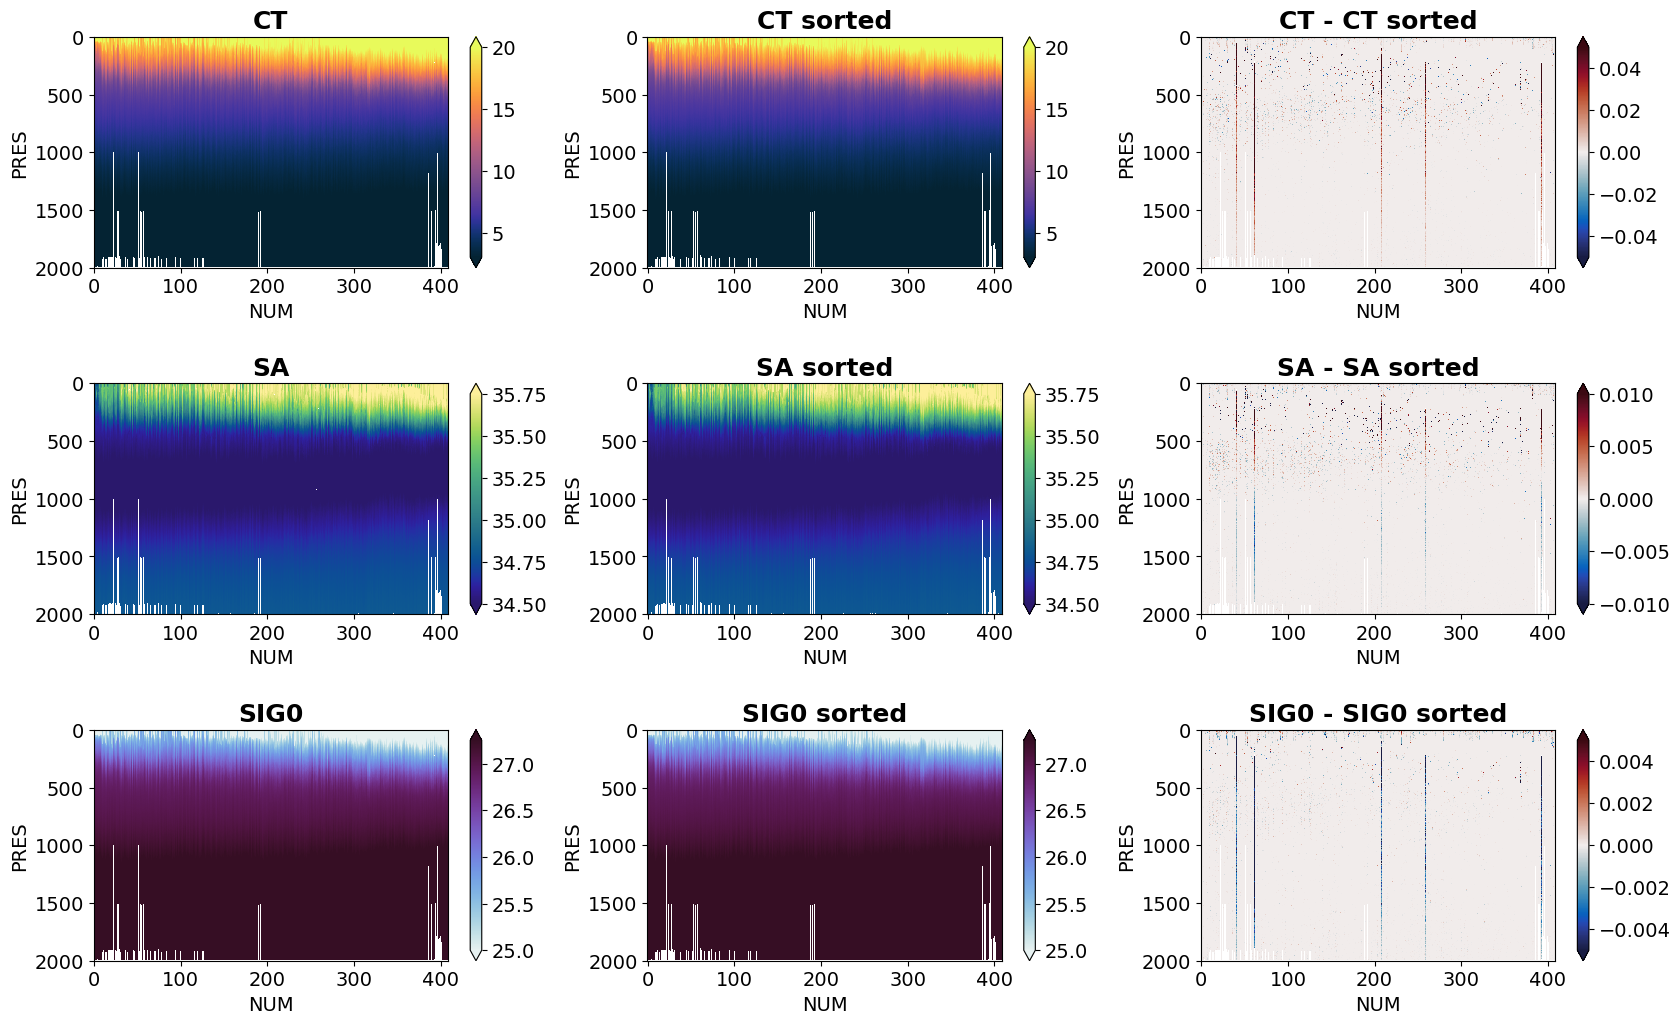

In [81]:
plt.figure(figsize=(20,12))

plt.subplot(331)
section_p.CT.plot(x=x, y='PRES', cmap=cmo.thermal, vmin=3, vmax=20, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(332)
section_p.CT_sorted.plot(x=x, y='PRES', cmap=cmo.thermal, vmin=3, vmax=20, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT sorted')

plt.subplot(333)
(section_p.CT - section_p.CT_sorted).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.05, vmax=0.05, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT - CT sorted')

plt.subplot(334)
section_p.SA.plot(x=x, y='PRES', cmap=cmo.haline, vmin=34.5, vmax=35.75, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(335)
section_p.SA_sorted.plot(x=x, y='PRES', cmap=cmo.haline, vmin=34.5, vmax=35.75, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA sorted')

plt.subplot(336)
(section_p.SA - section_p.SA_sorted).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.01, vmax=0.01, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA - SA sorted')

plt.subplot(337)
section_p.SIG0.plot(x=x, y='PRES', cmap=cmo.dense, vmin=25, vmax=27.25, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplot(338)
section_p.SIG0_sorted.plot(x=x, y='PRES', cmap=cmo.dense, vmin=25, vmax=27.25, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG0 sorted')

plt.subplot(339)
(section_p.SIG0 - section_p.SIG0_sorted).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.005, vmax=0.005, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG0 - SIG0 sorted')

plt.subplots_adjust(wspace=0.25, hspace=0.5)